In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

## Dataset

This isnt actually in use, just to test datagen code. The datagen function is directly coded in training method in model.

In [2]:
# Dataclass for adding problem

class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [3]:
n_data = 2000
t_steps = 40

# data,labels = datagen_full_sum_normal(n_data,t_steps,normalize=True)
data,labels = datagen_lowetal(n_data,t_steps)
# data,labels = datagen_timewise_labels(n_data,t_steps,2)
# print(data[1],labels[1])

BATCH_SIZE = 64

training_data = Datamodel(data,labels)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

data.shape

torch.Size([2000, 40, 1])

In [4]:
k = 10

print(labels[k])
print(data[k])

tensor([[ 0.0475,  0.9989],
        [-0.5181,  0.8553],
        [-0.1153,  0.9933],
        [-0.1545,  0.9880],
        [ 0.5882,  0.8087],
        [-0.1179,  0.9930],
        [ 0.3813,  0.9244],
        [ 0.3480,  0.9375],
        [-0.0444,  0.9990],
        [-0.6103,  0.7922],
        [-0.4341,  0.9009],
        [ 0.0992,  0.9951],
        [ 0.5460,  0.8378],
        [-0.2410,  0.9705],
        [-0.2247,  0.9744],
        [-0.0830,  0.9965],
        [ 0.0608,  0.9982],
        [ 0.5240,  0.8517],
        [-0.2033,  0.9791],
        [ 0.0388,  0.9992],
        [-0.1589,  0.9873],
        [ 0.2032,  0.9791],
        [ 0.1893,  0.9819],
        [ 0.1411,  0.9900],
        [ 0.0400,  0.9992],
        [ 0.1992,  0.9800],
        [-0.0199,  0.9998],
        [ 0.0057,  1.0000],
        [ 0.2431,  0.9700],
        [-0.2605,  0.9655],
        [ 0.3628,  0.9319],
        [-0.0688,  0.9976],
        [-0.3209,  0.9471],
        [-0.0025,  1.0000],
        [ 0.0775,  0.9970],
        [ 0.2622,  0

## Model training

100%|██████████| 2000/2000 [00:38<00:00, 51.99it/s]


Losses array was not a multiple of average. Truncated to 1980


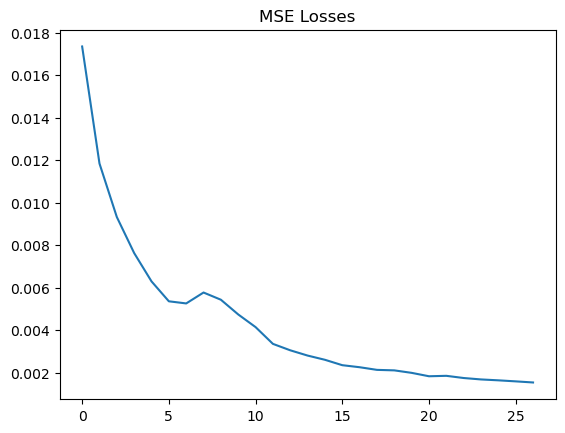

Guess on the first 15 training data:  tensor([[[ 1.0524,  2.2081],
         [ 0.7470,  1.8083],
         [ 0.5051,  1.4917],
         ...,
         [ 0.2942,  1.2156],
         [ 0.3323,  1.2654],
         [ 0.8413,  1.9317]],

        [[ 0.1699,  0.9720],
         [ 0.4254,  0.9169],
         [ 0.0142,  0.9334],
         ...,
         [ 0.1963,  0.9046],
         [ 0.1711,  0.9089],
         [ 0.3453,  0.9348]],

        [[ 0.3221,  0.9550],
         [ 0.1098,  0.9541],
         [-0.1270,  0.9819],
         ...,
         [ 0.1843,  0.9612],
         [ 0.2128,  0.9583],
         [-0.0503,  0.9653]],

        ...,

        [[-0.0746,  1.0185],
         [ 0.1372,  1.0139],
         [-0.0765,  1.0068],
         ...,
         [ 0.1113,  1.0050],
         [-0.0044,  1.0229],
         [-0.3458,  0.9297]],

        [[-0.0564,  1.0182],
         [-0.0195,  1.0143],
         [ 0.2458,  0.9791],
         ...,
         [-0.0296,  1.0054],
         [ 0.3331,  0.9737],
         [ 0.4326,  0.9116]],

In [5]:
hidden_size = 128
input_size = 1
nav_size = 2

train1 = True

if train1:
    # model2 = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.01,irnn=True,outputnn=False,Wx_normalize=True)
    # model1 = torch_RNN_full_manual(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False,outputnn=True,Wx_normalize=False,activation=False)
    # model1 = RNN_L2(input_size,t_steps,output_size,hidden_size,lr=0.001,w_decay=0.000,act_decay=1000,irnn=False,outputnn=True,Wx_normalize=False,activation=False)
    # model1 = RNN_circular_ND_pm(input_size,t_steps,output_size,hidden_size,lr=0.0001,w_decay=0.000,act_decay=0.01,irnn=True,outputnn=False,Wx_normalize=False,activation=True,rotation_init=False,bias=False)
    model1 = RNN_circular_LowEtAl(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=True,Wx_normalize=False,activation=True,bias=True,nav_space=1,batch_size=124)
    # print("Guess on the first 15 training data: ", model1(data[0:15]))
    _ = model1.train_gradual(epochs=2000)
    model1.plot_losses(average=30)
    # model1.plot_accs()
    print("Guess on the first 15 training data: ", model1(data[0:15]))
    # print("Weight of the hidden layer: ",model2.rnn.weight_hh_l0, " Weight of the input layer: ",model2.rnn.weight_ih_l0)

In [13]:
# _ = model1.train(epochs=4000)
# model1.plot_losses(average=30)

torch.Size([41, 15])


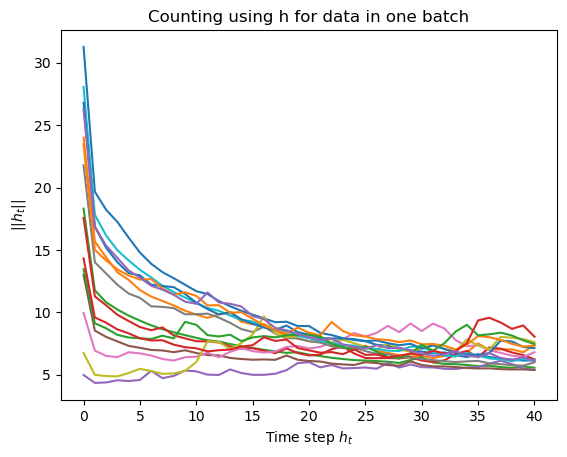

In [6]:
print(model1.hts.norm(dim=2).shape)
htss = model1.hts.norm(dim=2)
plt.plot(htss.detach().numpy())
plt.title("Counting using h for data in one batch")
plt.xlabel(r"Time step $h_t$")
plt.ylabel(r"$||h_t||$")
plt.show()

torch.Size([41, 15, 128])


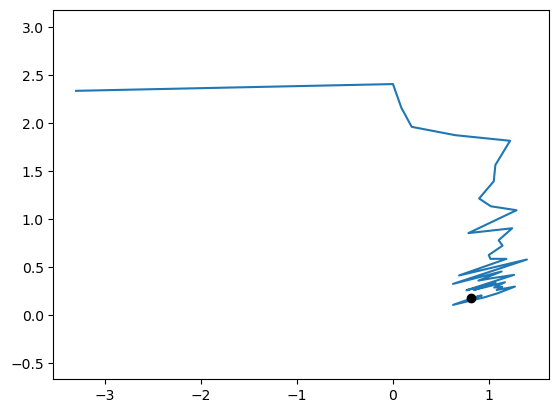

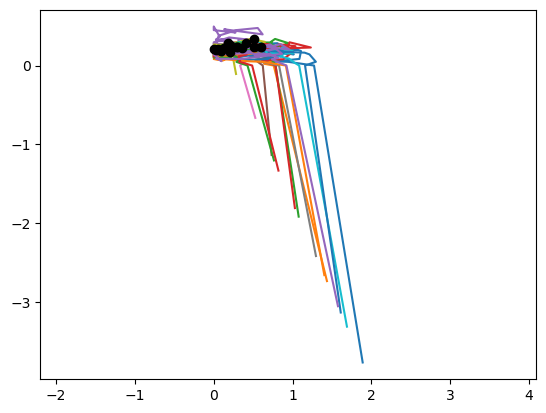

In [7]:
n = 0
print(model1.hts.shape)
model1.hts[:,n,:].shape
hts_cric = model1.hts.detach().numpy()
plt.plot(hts_cric[:,n,86],hts_cric[:,n,26],"-")
plt.plot(hts_cric[-1,n,86],hts_cric[-1,n,26],"o",color="black")
plt.axis("equal")
plt.show()
plt.plot(hts_cric[:,:,16],hts_cric[:,:,125],"-")
plt.plot(hts_cric[-1,:,16],hts_cric[-1,:,125],"o",color="black")
plt.axis("equal")
plt.show()

In [8]:
# See what dimension has the highest values

maxs = []

for i in range(128):
    maxs.append(max(hts_cric[:,n,i]))

# Sorted dimension from lowest to highest value in that dimension
print(torch.argsort(torch.tensor(maxs),dim=-1))

tensor([ 28, 102,  82,  92, 114, 119, 127,  44,  89,  36,  80,  73,  42,  39,
         40,  14,  56,   2,  64,  18,  27,  50, 101,  62,  46, 117,   8,  68,
         26, 126,  93, 108,  60, 110,  84, 122,  41,  81,  53, 121,  22,  83,
         16,  34, 123,  57,  35,   1,  78,  23, 105,  61,  67,  63,  65,  54,
        103,  77,  58,  69,  85,  88,  79,  19,   6, 113,  55,  71, 111, 104,
         91,  45, 124,  48,  95,   3,  97, 106, 115, 112,  76, 118,  24,  52,
         10,  17,  72,  75, 109,  51,  11, 125,  96,  20,   7,  90,  43,  70,
         99,  33,  13,  15,  47,  37,  59,  12,  94,  30, 120,  29,   5,   4,
        100,  49,  86,  38,  98,   0,  25,   9, 116,  87,  31,  66,  74,  21,
        107,  32])


(19, 1000)
(19, 1000)


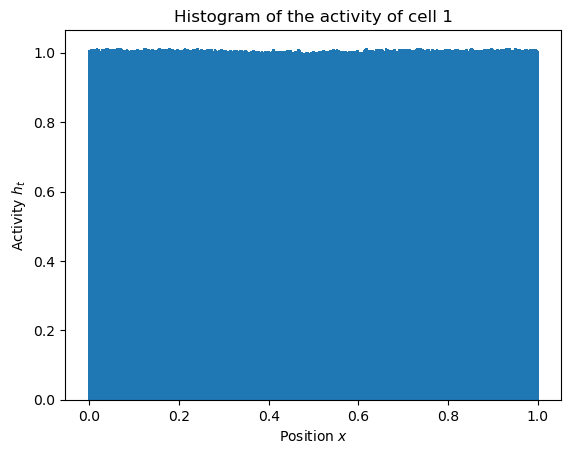

  2%|▏         | 2/128 [00:00<00:00, 477.85it/s]


IndexError: index 2 is out of bounds for axis 2 with size 2

In [9]:
t_test = 20

data,labels = datagen_truecircular_pm(1000,t_test)

test_batch_size = 5000

# xs = data[0:test_batch_size]
xs = labels[0:test_batch_size,:-1]/(2*np.pi)
xs = xs.detach().numpy().T
print(xs.shape)

# Get the hidden states for the test data
hts = model1(data[0:test_batch_size])

# Grid-cell histogram

hts = hts.detach().numpy() # Shape [t_steps, batch_size, hidden_size] = [21, 64, 128]

k = 1 # What cell to see the histogram of
hts_k = abs(hts[1:-1,:,k])
print(hts_k.shape)

bins = 1000

import scipy.stats as stats

bin_means, bin_edges, binnumber = stats.binned_statistic(xs.flatten(),hts_k.flatten(),statistic='mean',bins=bins)
# Bar plot of the histogram
plt.bar(bin_edges[:-1],bin_means,width=6/bins)
plt.title("Histogram of the activity of cell "+str(k))
plt.xlabel(r"Position $x$")
plt.ylabel(r"Activity $h_t$")
plt.show()

# print(hts.shape)

# fig, ax = plt.subplots(32,4,subplot_kw={'projection': 'polar'})
# fig.set_size_inches(15, 80)
# fig.subplots_adjust(hspace=1,wspace=0.2)

activity = np.zeros((128,bins))

for k in tqdm(range(128)):
    # k = 103 # What cell to see the histogram of
    hts_k = abs(hts[1:-1,:,k])
    # print(hts_k.shape)

    # Bins equally spaced from 0 to 1 in time_steps amount of bins
    bin_means, bin_edges, binnumber = stats.binned_statistic(xs.flatten(),hts_k.flatten(),statistic='mean',bins=bins)
    activity[k,:] = bin_means
    np.nan_to_num(activity,copy=False)
    # Bar plot of the histogram
    # ax[k//4,k%4].bar(bin_edges[:-1]*2*np.pi,bin_means,width=6/bins)
    # # ax[].bar(bin_edges[:-1]*2*np.pi,bin_means,width=6/bins)
    # ax[k//4,k%4].set_title("Cell "+str(k))
    # Adjust space between subplots

# plt.show()

c:\Users\matti\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1000, 2)


Text(0.5, 1.0, 'UMAP projection of the activity of the grid cells')

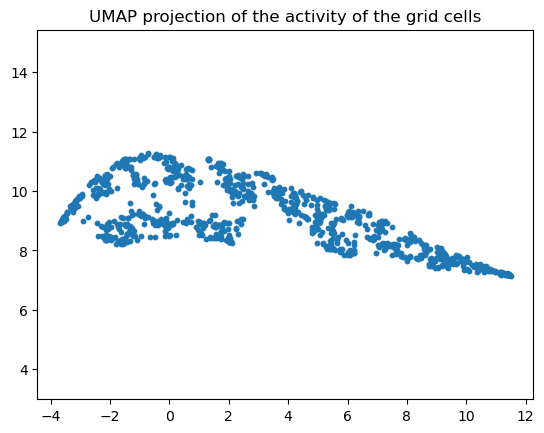

In [10]:
import umap

# draw_umap(activity.T,n_components=2, title='UMAP projection of the activity of the grid cells')
reducer = umap.UMAP(n_neighbors=500, n_components=2,min_dist=0.00,repulsion_strength=1)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)

print(embedding.shape)


plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the activity of the grid cells', fontsize=12)


In [ ]:
print(model1(data[10:11]))
print(data[10:11])
print(labels[10:11])

tensor([[[ 0.1055,  0.0669,  0.1516,  ...,  0.0904,  0.1251,  0.0954]],

        [[-0.0956,  0.0814, -0.1746,  ..., -0.0153, -0.0323,  0.0379]],

        [[-0.1115,  0.0777, -0.1974,  ..., -0.0180, -0.0404,  0.0351]],

        ...,

        [[-0.0654,  0.0343, -0.1950,  ..., -0.0230, -0.0484,  0.0391]],

        [[-0.0154,  0.0981, -0.1762,  ..., -0.0817, -0.0550,  0.0429]],

        [[ 0.0051,  0.1408, -0.1646,  ..., -0.1156, -0.0560,  0.0460]]],
       grad_fn=<CopySlices>)
tensor([[[-0.0619],
         [-0.0358],
         [ 0.0073],
         [-0.0864],
         [-0.0534],
         [ 0.0194],
         [-0.0491],
         [ 0.1392],
         [-0.1114],
         [ 0.0355],
         [ 0.1629],
         [ 0.1136],
         [-0.0255],
         [-0.0094],
         [ 0.0036],
         [ 0.1031],
         [ 0.0064],
         [ 0.1967],
         [-0.0274],
         [-0.1816]]])
tensor([[2.7526, 2.5278, 2.5736, 2.0305, 1.6948, 1.8169, 1.5083, 2.3832, 1.6832,
         1.9065, 2.9303, 3.6444, 3.4

(-1.0999622195959091,
 1.0999514311552048,
 -1.0978460788726807,
 1.0998974323272706)

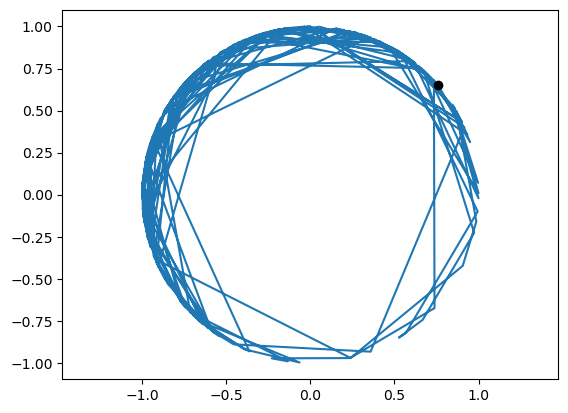

In [ ]:
t_test = 200

data,labels = datagen_truecircular_pm(1000,t_test)

# Plot circle from data
data_raw = labels[122].detach().numpy()
# print(data_raw)
data_points = np.zeros((t_test,2))
for i in range(t_test):
    data_points[i,0] = np.cos(data_raw[i])
    data_points[i,1] = np.sin(data_raw[i])


plt.plot(data_points[:,0],data_points[:,1],"-")
plt.plot(data_points[-1,0],data_points[-1,1],"o",color="black")
plt.axis("equal")

In [ ]:
# print(model1.input.weight)
print(model1.hidden.weight)
# print(model1.Wh_init)
# print(model1.output.weight)

Parameter containing:
tensor([[ 9.7316e-01, -2.3343e-02, -2.1827e-02,  ..., -1.0315e-02,
         -2.2785e-02, -2.1353e-02],
        [-1.0513e-02,  9.9223e-01, -6.7781e-03,  ...,  1.1700e-02,
          2.7143e-03, -9.6948e-04],
        [-3.3636e-02, -2.8345e-02,  9.6900e-01,  ..., -2.7289e-02,
         -3.9259e-02, -3.7641e-02],
        ...,
        [ 5.2839e-03,  1.8591e-03, -4.1440e-03,  ...,  9.8374e-01,
         -1.6406e-02, -1.4466e-02],
        [-1.1366e-02, -9.8762e-03, -1.3468e-02,  ..., -1.3232e-02,
          9.7735e-01, -1.9435e-02],
        [-5.0514e-03, -3.9373e-03, -6.7584e-03,  ..., -3.0696e-03,
         -9.5602e-03,  9.9180e-01]], requires_grad=True)


In [ ]:
# hc = 0
# for h in model2.hts[0][0]:
#     hc += h

# np.linalg.norm(model2.hts[0,0].detach().numpy())
an1 = model1.hts[:,0,:]
an1 = an1.detach().numpy()
print(an1.shape)

for i in range(1,len(an1)):
    an1_i_normalized = an1[i]/np.linalg.norm(an1[i])
    an1_i_minus_1_normalized = an1[i-1]/np.linalg.norm(an1[i-1])
    # print(an1_i_normalized @ an1_i_minus_1_normalized)
    # Angle between an1[i] and an1[i-1]
    ang = np.arccos(an1_i_normalized @ an1_i_minus_1_normalized)
    print(np.rad2deg(ang))



(21, 128)
91.17524
5.4347663
10.312174
18.916992
5.3038926
16.401665
13.736627
43.95155
52.18017
30.026196
32.39579
8.940481
29.03002
3.158395
4.1127076
23.23665
17.50475
33.120438
34.14431
36.329033


In [ ]:
# SVD of the weight matrix Wh

Wh = model1.hidden.weight.detach().numpy()
U, s, Vh = np.linalg.svd(Wh)
print("Singular values of Wh: ",s)

np.prod(s)
np.linalg.det(Wh)

Singular values of Wh:  [1.4707302  1.1603389  1.0616848  1.0450305  1.0241089  1.0127574
 1.0052571  1.0035334  1.0028872  1.0020396  1.0013726  1.0007275
 1.0005453  1.0003867  1.0003132  1.000235   1.0002092  1.0001669
 1.0001167  1.0001026  1.0000905  1.0000839  1.0000764  1.0000659
 1.0000635  1.0000535  1.0000511  1.0000417  1.0000359  1.0000209
 1.0000145  1.0000134  1.0000119  1.0000075  1.0000068  1.0000043
 1.0000023  1.0000017  1.0000014  1.0000013  1.0000013  1.0000012
 1.0000011  1.0000011  1.000001   1.0000008  1.0000007  1.0000007
 1.0000006  1.0000006  1.0000006  1.0000005  1.0000005  1.0000004
 1.0000004  1.0000002  1.0000002  1.0000002  1.0000002  1.0000002
 1.0000002  1.0000002  1.0000001  1.0000001  1.         1.
 0.99999994 0.9999999  0.9999999  0.9999999  0.9999998  0.9999998
 0.99999976 0.9999997  0.99999964 0.99999964 0.9999995  0.99999946
 0.99999934 0.9999993  0.9999992  0.999999   0.9999989  0.9999988
 0.9999987  0.99999857 0.99999845 0.9999983  0.99999803 0.

0.0021133139

### Test baseline loss if you guess only zeros

In [ ]:
y_hat = labels
act_decay = 0.01
time_steps = t_steps
# y = torch.ones(time_steps+1,y_hat.shape[0],hidden_size)/np.sqrt(hidden_size)
y = torch.zeros(time_steps+1,y_hat.shape[0],hidden_size)
y[:,:,4] = 0
y[:,:,0] = 1

activity_L2 = act_decay*((torch.norm(y,dim=-1)-1)**2).sum()

# Concatenate 0 to y_hat to make it the same size as y
y_hat = torch.cat((torch.zeros(y_hat.size(0),1),y_hat),dim=1)
# Permute y_hat to make it the same size as y
y_hat = y_hat.permute(1,0)
# angle_loss = 0


# Theoretical 0 loss
# print(y_hat.shape)
# # y = torch.zeros(time_steps+1,y_hat.shape[0],hidden_size)
# print(y.shape)
# for i in range(t_steps+1):
#     y[i,:,0] = torch.cos(y_hat[i])
#     y[i,:,1] = torch.sin(y_hat[i])

# print((torch.norm(y,dim=-1).shape))


        


# Main angle loss loop
i = torch.arange(1, time_steps).unsqueeze(1)
j = torch.arange(1, time_steps//2-int(time_steps*0.1)).unsqueeze(0)
mask = (i > j).float()
j = j * mask
# Convert i and j to int
i = i.long()
j = j.long()
normalizer = 1 / (torch.norm(y[i], dim=-1) * torch.norm(y[i-j], dim=-1))
# Cant clamp between -1 and 1 because it will cause NaNs in training
angle_test = torch.abs(torch.acos(torch.clamp(torch.sum(y[i]*y[i-j], dim=-1) * normalizer, -0.999999, 0.999999)))
# Must use torch.abs because the angle can be negative, but the angle_test only returns positive angles
angle_theoretical = torch.abs(y_hat[i]-y_hat[i-j])
angle_loss = torch.mean((angle_test-angle_theoretical)**2)

# Loss to end in the same position as the start
# circle_end_loss = 0.0001*torch.mean((y[-1]-y[0])**2)

# losses_circle.append(circle_end_loss.item())
loss = angle_loss + activity_L2 # + circle_end_loss

loss
# loss
# torch.norm(y[1,0,:])
# y_hat.shape
# j1 = 16
# i1 = 1
# a = torch.abs(torch.acos(torch.clamp(torch.sum(y[i1,0,:]*y[j1,0,:], dim=-1) * (torch.norm(y[i1,0,:], dim=-1) * torch.norm(y[j1,0,:], dim=-1)), -0.99999, 0.99999)))
# b = y_hat[i1,0]-y_hat[j1,0]
# (a-abs(b))**2
# print(angle_theoretical[:,:,0])
# print(angle_test[:,:,0])
# torch.mean((angle_test-angle_theoretical)**2)

tensor(1.0241)

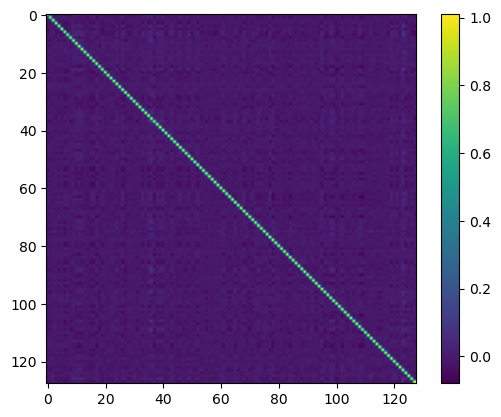

In [ ]:
plt.imshow(model1.hidden.weight.detach().numpy())
plt.colorbar()

In [ ]:
Wx = model1.input.weight.detach().numpy()
print("Norm of Wx: ",np.linalg.norm(Wx))

Norm of Wx:  5.690291
